# CICIDS2017 Dataset

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Display settings
pd.set_option('display.max_columns', None)
print("Libraries imported successfully.")

Libraries imported successfully.


### Load the Dataset

In [2]:
df = pd.read_csv('cicids2017.csv', low_memory=False)

print(f"Original Dataset Shape: {df.shape}")
df.head()

Original Dataset Shape: (50000, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,9392887,4,0,24,0,6,6,6.000000,0.000000,0,0,0.000000,0.000000,2.555125e+00,0.425854,3.130962e+06,5.421269e+06,9390905,975,9392887,3.130962e+06,5.421269e+06,9390905,975,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,80,0,0.425854,0.000000,6,6,6.000000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,0,7.500000,6.000000,0.000000,80,0,0,0,0,0,0,4,24,0,0,256,-1,3,20,1.982000e+03,0.0000,1982,1982,9390905.0,0.0000,9390905,9390905,DDoS
1,64007,5438011,1,5,6,30,6,6,6.000000,0.000000,6,6,6.000000,0.000000,6.620068e+00,1.103345,1.087602e+06,2.416784e+06,5410860,3,0,0.000000e+00,0.000000e+00,0,0,5422871,1.355718e+06,2.703434e+06,5410860,3,0,0,0,0,20,100,0.183891,0.919454,6,6,6.000000,0.000000,0.000000e+00,0,0,0,0,1,1,0,0,5,7.000000,6.000000,6.000000,20,0,0,0,0,0,0,1,6,5,30,229,0,0,20,2.715100e+04,0.0000,27151,27151,5410860.0,0.0000,5410860,5410860,BENIGN
2,80,115615609,20,15,1728,3463,578,0,86.400000,211.017934,1734,0,230.866667,514.538471,4.489878e+01,0.302727,3.400459e+06,4.722346e+06,10100000,17,116000000,6.085032e+06,5.002940e+06,10200000,118,113000000,8.061410e+06,4.296214e+06,10200000,121410,0,0,0,0,648,488,0.172987,0.129740,0,1734,144.194444,368.503446,1.357948e+05,0,0,0,1,0,0,0,0,0,148.314286,86.400000,230.866667,648,0,0,0,0,0,0,20,1728,15,3463,29200,255,3,32,1.609163e+05,134508.6864,566475,120118,10100000.0,46752.4843,10100000,9988018,BENIGN
3,80,9827,3,5,26,11601,20,0,8.666667,10.263203,7300,0,2320.200000,3022.508098,1.183169e+06,814.083647,1.403857e+03,2.919354e+03,7954,4,8005,4.002500e+03,5.654733e+03,8001,4,9780,2.445000e+03,3.835651e+03,8150,190,0,0,0,0,72,112,305.281368,508.802279,0,7300,1291.888889,2460.652985,6.054813e+06,0,0,0,1,0,0,0,0,1,1453.375000,8.666667,2320.200000,72,0,0,0,0,0,0,3,26,5,11601,8192,229,2,20,0.000000e+00,0.0000,0,0,0.0,0.0000,0,0,DDoS
4,53315,87583370,7,9,11607,62,4380,0,1658.142857,1762.272815,20,0,6.888889,5.301991,1.332331e+02,0.182683,5.838891e+06,2.130000e+07,82600000,0,87600000,1.460000e+07,3.540000e+07,86800000,49,86900000,1.090000e+07,2.900000e+07,82600000,0,0,0,0,0,152,192,0.079924,0.102759,0,4380,686.764706,1366.162670,1.866400e+06,0,0,0,0,1,1,0,0,1,729.687500,1658.142857,6.888889,152,0,0,0,0,0,0,7,11607,9,62,229,256,5,20,4.219842e+06,0.0000,4219842,4219842,82600000.0,0.0000,82600000,82600000,BENIGN


### Data Cleaning

In [3]:
#Shape before cleaning
print(f"Shape before Cleaning: {df.shape}")

#Shape after cleaning
# 1. Clean Column Names (remove extra spaces often found in CIC datasets)
df.columns = df.columns.str.strip()

# 2. Handle Infinite and Missing Values
# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN values
df.dropna(inplace=True)

# 3. Remove Duplicates
df.drop_duplicates(inplace=True)

print(f"Shape after Cleaning: {df.shape}")

Shape before Cleaning: (50000, 79)
Shape after Cleaning: (49742, 79)


### Label Encoding

In [4]:
le = LabelEncoder()

df['Label'] = le.fit_transform(df['Label'])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Label Mapping: {label_mapping}")

Label Mapping: {'BENIGN': np.int64(0), 'DDoS': np.int64(1)}


### Initial Feature Reduction & Splitting

In [5]:
X = df.drop('Label', axis=1)
y = df['Label']

# Select only numeric features (this usually removes IPs, Timestamps, Flow IDs)
X = X.select_dtypes(include=[np.number])

print(f"Features reduced to: {X.shape[1]}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Features reduced to: 78
Training shape: (34819, 78)
Testing shape: (14923, 78)


### Normalization (StandardScaler)

In [6]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Normalization complete.")

Normalization complete.


### Handling Class Imbalance (SMOTE)

In [7]:
smote = SMOTE(random_state=42)

# Resample the training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"Original Training Target Counts: {np.bincount(y_train)}")
print(f"Balanced Training Target Counts: {np.bincount(y_train_balanced)}")

Original Training Target Counts: [14867 19952]
Balanced Training Target Counts: [19952 19952]


### Feature Selection using PCA

In [8]:
pca = PCA(n_components=0.95) 

X_train_pca = pca.fit_transform(X_train_balanced)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original Feature Count: {X_train_balanced.shape[1]}")
print(f"PCA Reduced Feature Count: {X_train_pca.shape[1]}")

Original Feature Count: 78
PCA Reduced Feature Count: 21


### Random Forest Model

Training Random Forest Model...
Predicting on Test Set...
RANDOM FOREST RESULTS
Accuracy:  0.9994 (Paper achieved ~98.9%)
Precision: 0.9995
Recall:    0.9994
F1-Score:  0.9995

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6372
           1       1.00      1.00      1.00      8551

    accuracy                           1.00     14923
   macro avg       1.00      1.00      1.00     14923
weighted avg       1.00      1.00      1.00     14923



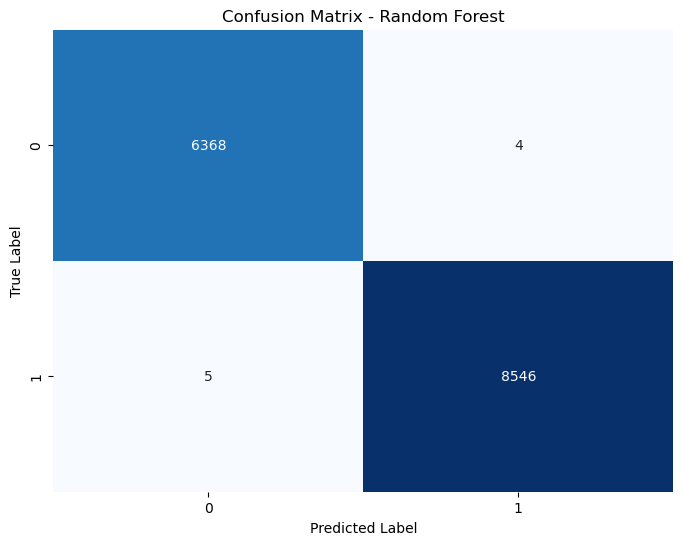

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# 1. Initialize the Random Forest Classifier
# The paper does not specify the exact number of trees (n_estimators),
# but 100 is a standard default that usually yields high results.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Train the Model
print("Training Random Forest Model...")
rf_model.fit(X_train_pca, y_train_balanced)

# 3. Make Predictions
print("Predicting on Test Set...")
y_pred_rf = rf_model.predict(X_test_pca)

# 4. Evaluate Performance
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print("RANDOM FOREST RESULTS")
print(f"Accuracy:  {rf_accuracy:.4f} (Paper achieved ~98.9%)")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1-Score:  {rf_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# 5. Visualizing the Confusion Matrix (Matching Fig. 2a in the paper)
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()